In [1]:
import pickle
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

def load_dataset(imbalance = True):
    DIR = os.getcwd()
    data_path = os.path.join(DIR, 'labeled_dump')
    data_list = sorted(os.listdir(data_path))
    
    if imbalance == False:
        index = 1
    else:
        index = 0
        
    for idx, data in enumerate(data_list[index:index+1]):
        with open(os.path.join(data_path, data), 'rb') as f:
            if idx == 0:
                dataset = pickle.load(f)
            else:
                dataset = np.concatenate((dataset, pickle.load(f)))

    print('DEVICE \t\t: ', DEVICE)
    print('pid \t\t: ', os.getpid())
    print('data length \t: ', len(dataset))

    print('\n---------------------------------Data---------------------------------')

    class SeismicDataset(Dataset): 
        def __init__(self, xs, ys):
            self.x_data = xs
            self.y_data = ys

        def __len__(self): 
            return len(self.x_data)

        def __getitem__(self, idx): 
            x = self.x_data[idx]
            y = self.y_data[idx]
            return x, y

    def make_x_p_s(dataset):

    #     x = np.array([(dataset[i]['data'].T - np.min(dataset[i]['data']))/(np.max(dataset[i]['data']) - np.min(dataset[i]['data'])) for i in range(len(dataset))])
        x = np.array([dataset[i]['data'].T for i in range(len(dataset))])
        y_p = np.array([dataset[i]['p_label'] for i in range(len(dataset))])[:,np.newaxis]
        y_s = np.array([dataset[i]['s_label'] for i in range(len(dataset))])[:,np.newaxis]


        return torch.as_tensor(x.astype(np.float32)), torch.as_tensor(y_p.astype(np.float32)), torch.as_tensor(y_s.astype(np.float32))

    def train_test_valid_split(dataset):
        train, test = train_test_split(dataset, 
                                       test_size=0.2, 
                                       shuffle=True, 
                                       random_state=1004)
        valid = test[int(0.75*len(test)):]
        test = test[:int(0.75*len(test))]

        return train, test, valid

    x, y_p, y_s = make_x_p_s(dataset)

    train_x, valid_x, test_x  = train_test_valid_split(x)
    train_y_p, valid_y_p, test_y_p  = train_test_valid_split(y_p)
    train_y_s, valid_y_s, test_y_s = train_test_valid_split(y_s)

    print('x shape \t:', x.shape)
    print('y_p shape \t:',y_p.shape)
    print('Train size \t:',  len(train_x))
    print('Valid size \t:', len(valid_x))
    print('Test size \t:', len(test_x))

    print('\n------------------------------Data Loader------------------------------')

    train_loader = DataLoader(
        dataset=SeismicDataset(train_x, train_y_p), batch_size=500, shuffle=True
    )
    valid_loader = DataLoader(
        dataset=SeismicDataset(test_x, test_y_p), batch_size=500, shuffle=True
    )
    test_loader = DataLoader(
        dataset=SeismicDataset(valid_x, valid_y_p), batch_size=500, shuffle=True
    )

    for (X_train, y_train) in train_loader : 
        print('X_train : ', X_train.size() , ' \ttype : ', X_train.type())
        print('y_train : ', y_train.size() , ' \t\ttype : ', y_train.type())
        break
        
    
    return len(train_x), train_loader, valid_loader, test_loader

train_length, train_loader, valid_loader, test_loader = load_dataset()

DEVICE 		:  cuda:1
pid 		:  7215
data length 	:  24185

---------------------------------Data---------------------------------
x shape 	: torch.Size([24185, 3, 12000])
y_p shape 	: torch.Size([24185, 1])
Train size 	: 19348
Valid size 	: 3627
Test size 	: 1210

------------------------------Data Loader------------------------------
X_train :  torch.Size([500, 3, 12000])  	type :  torch.FloatTensor
y_train :  torch.Size([500, 1])  		type :  torch.FloatTensor


In [2]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        kernel_size = 200
        self.conv1 = nn.Conv1d(3, 4, kernel_size=kernel_size, padding=kernel_size//2)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=(kernel_size-2), padding=(kernel_size-2)//2)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(kernel_size-4), padding=(kernel_size-4)//2)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(16, 32, kernel_size=(kernel_size-6), padding=(kernel_size-6)//2)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.5)
        
        
        self.relu5 = nn.ReLU()
        self.relu6 = nn.ReLU()
        
        self.fc1 = nn.Linear(in_features=32 * 750, out_features=1500)
        self.fc2 = nn.Linear(in_features=1500, out_features= 100)
        self.fc3 = nn.Linear(in_features=100, out_features=1) 
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inp):
        inp = inp.to(DEVICE, dtype=torch.float)
        out = self.conv1(inp)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.maxpool2(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.maxpool3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.maxpool4(out)
        
        out = out.view(-1, 32 * 750)
        
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.relu6(out)
        out = self.fc3(out)
        
        out = self.sigmoid(out)
        
        return out
    
def metric(test_outputs, test_y_p):
    cnt = 0
    TP = FP = TN = FN = 0 + sys.float_info.epsilon
    for idx in range(len(test_y_p)):
        if int(torch.round(test_outputs[idx])) == 1 and int(torch.round(test_y_p[idx])) == 1:
            TP += 1
        if int(torch.round(test_outputs[idx])) == 1 and int(torch.round(test_y_p[idx])) == 0:
            FP += 1
        if int(torch.round(test_outputs[idx])) == 0 and int(torch.round(test_y_p[idx])) == 0:
            TN += 1
        if int(torch.round(test_outputs[idx])) == 0 and int(torch.round(test_y_p[idx])) == 1:
            FN += 1
            
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2*(precision * recall)/(precision + recall)
    
    return accuracy, precision, recall, F1_score

def save_fig(model_name, epoch, plot_dict):
    DIR = os.getcwd()
    output_dir = os.path.join(DIR, 'outputs', model_name)
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    plt.figure(figsize=(10, 5))
    plt.plot(plot_dict['losses'])
    plt.plot(plot_dict['val_losses'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig(os.path.join(output_dir, model_name + '_' + str(epoch) + '_loss.png'))
    
    plt.figure(figsize=(10, 5))
    plt.plot(plot_dict['acc'])
    plt.plot(plot_dict['prec'])
    plt.plot(plot_dict['rec'])
    plt.plot(plot_dict['f1'])
    plt.legend(['val_accuracy', 'val_precision', 'val_recall', 'val_F1_score'], loc='lower right')
    plt.savefig(os.path.join(output_dir, model_name + '_' + str(epoch) + '_metric.png'))

 Epoch [1/100], Step [38/38], Loss: 0.9526, Val Loss: 0.7055 accuracy : 0.9260, precision : 0.5000, recall : 0.0000, F1_score : 0.0000
 Epoch [2/100], Step [38/38], Loss: 0.7102, Val Loss: 0.5833 accuracy : 0.9420, precision : 0.8333, recall : 0.1515, F1_score : 0.2564
 Epoch [3/100], Step [38/38], Loss: 0.3882, Val Loss: 0.4795 accuracy : 0.9500, precision : 0.9000, recall : 0.2727, F1_score : 0.4186
 Epoch [4/100], Step [38/38], Loss: 0.2605, Val Loss: 0.5226 accuracy : 0.9580, precision : 0.7143, recall : 0.2083, F1_score : 0.3226
 Epoch [5/100], Step [38/38], Loss: 0.2218, Val Loss: 0.4177 accuracy : 0.9480, precision : 0.8667, recall : 0.3514, F1_score : 0.5000
 Epoch [6/100], Step [38/38], Loss: 0.7307, Val Loss: 0.4462 accuracy : 0.9520, precision : 0.8889, recall : 0.2581, F1_score : 0.4000
 Epoch [7/100], Step [38/38], Loss: 0.2962, Val Loss: 0.4802 accuracy : 0.9640, precision : 0.8333, recall : 0.5882, F1_score : 0.6897
 Epoch [8/100], Step [38/38], Loss: 0.3414, Val Loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


 Epoch [81/100], Step [38/38], Loss: 0.0345, Val Loss: 0.3638 accuracy : 0.9560, precision : 0.7037, recall : 0.5758, F1_score : 0.6333
 Epoch [82/100], Step [38/38], Loss: 0.0565, Val Loss: 0.3274 accuracy : 0.9680, precision : 0.7500, recall : 0.7500, F1_score : 0.7500
 Epoch [83/100], Step [38/38], Loss: 0.0380, Val Loss: 0.3381 accuracy : 0.9680, precision : 0.8182, recall : 0.7297, F1_score : 0.7714
 Epoch [84/100], Step [38/38], Loss: 0.0411, Val Loss: 0.1603 accuracy : 0.9740, precision : 0.8966, recall : 0.7222, F1_score : 0.8000
 Epoch [85/100], Step [38/38], Loss: 0.0415, Val Loss: 0.3233 accuracy : 0.9720, precision : 0.8065, recall : 0.7576, F1_score : 0.7812
 Epoch [86/100], Step [38/38], Loss: 0.0613, Val Loss: 0.1429 accuracy : 0.9700, precision : 0.7333, recall : 0.7586, F1_score : 0.7458
 Epoch [87/100], Step [38/38], Loss: 0.0417, Val Loss: 0.1341 accuracy : 0.9640, precision : 0.7333, recall : 0.6875, F1_score : 0.7097
 Epoch [88/100], Step [38/38], Loss: 0.0370, Val

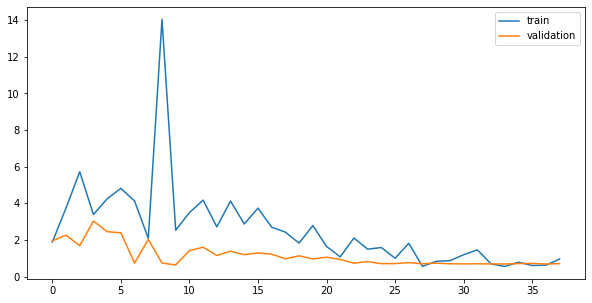

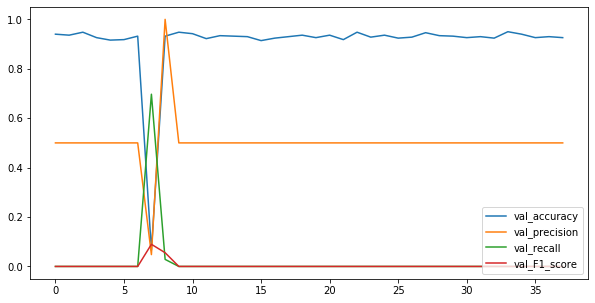

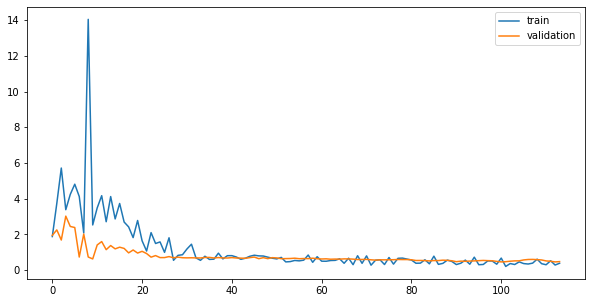

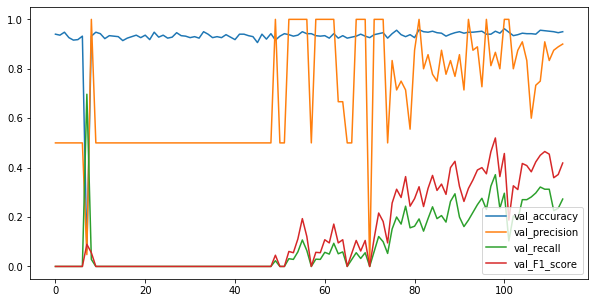

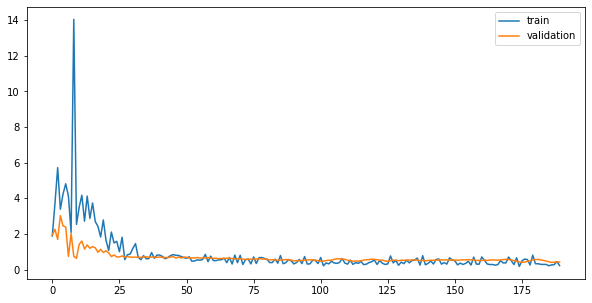

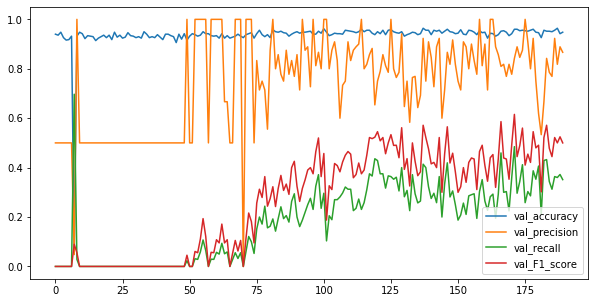

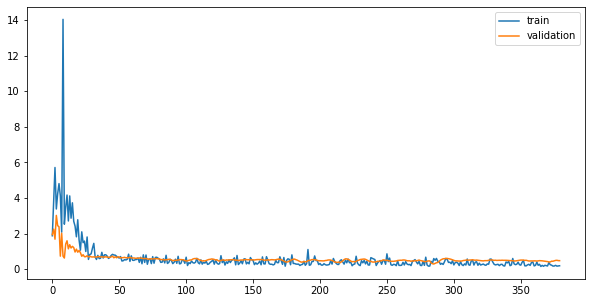

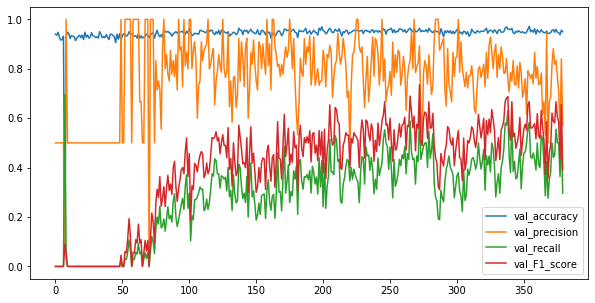

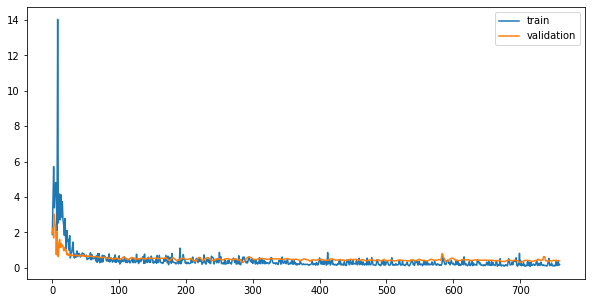

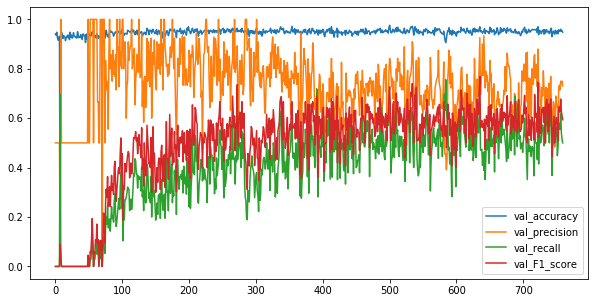

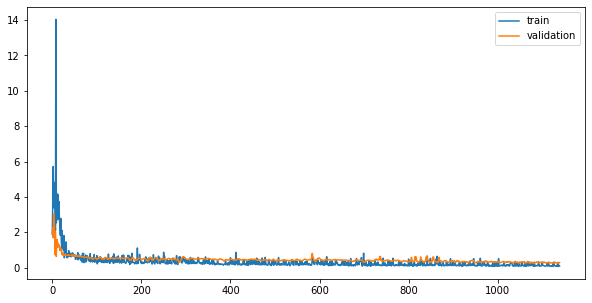

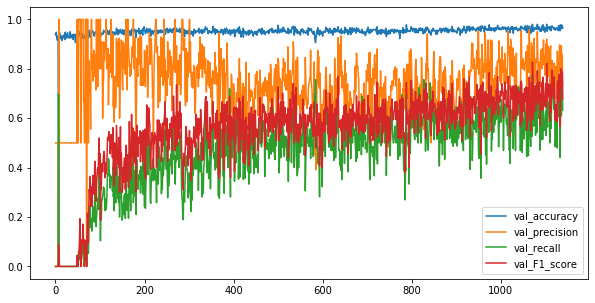

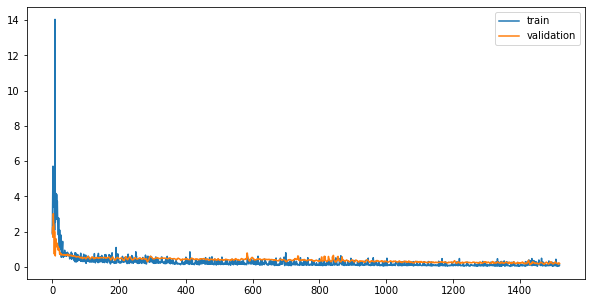

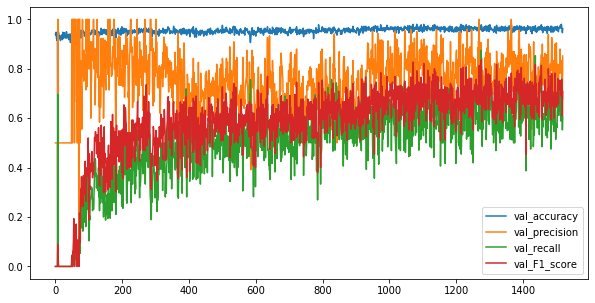

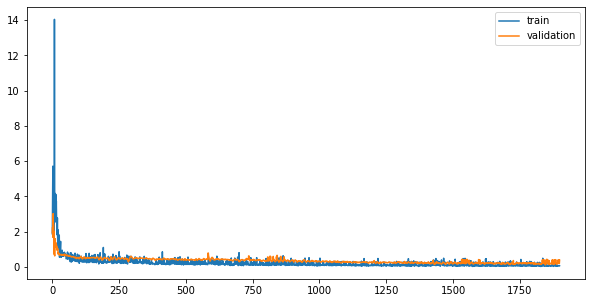

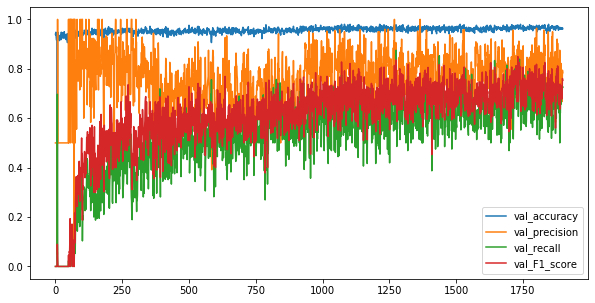

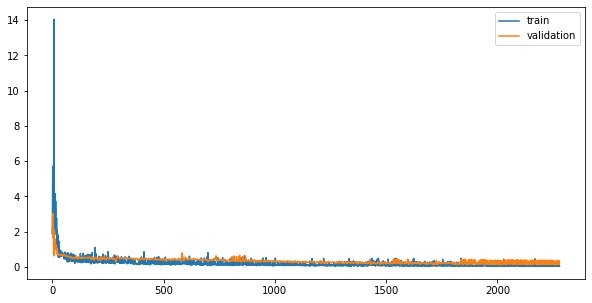

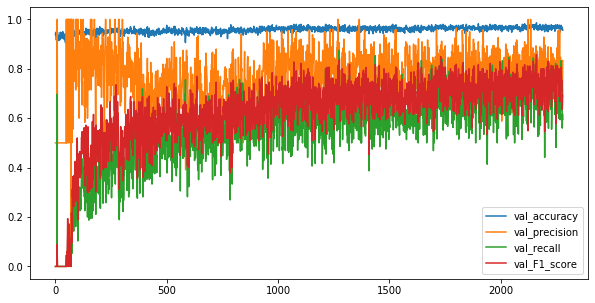

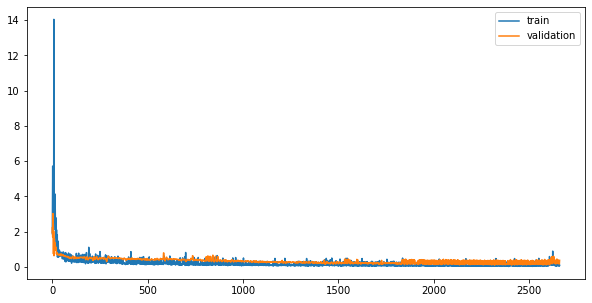

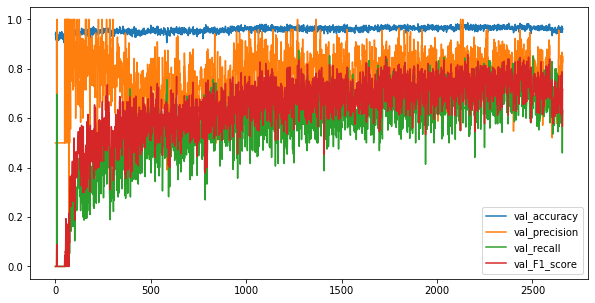

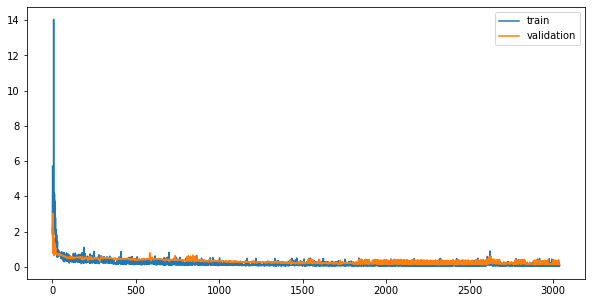

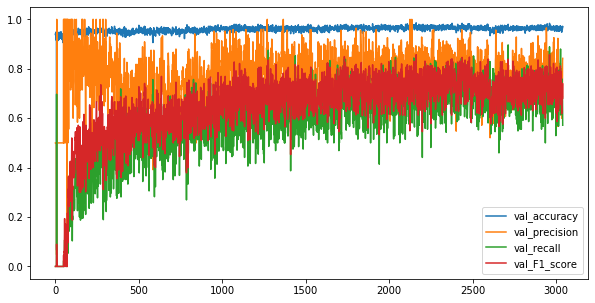

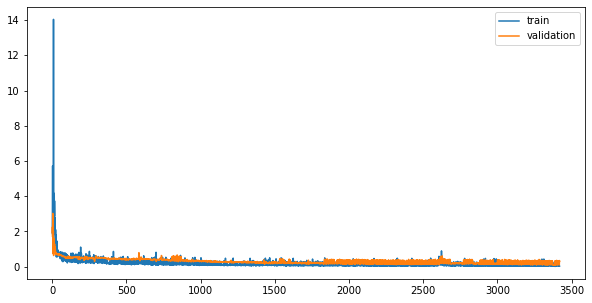

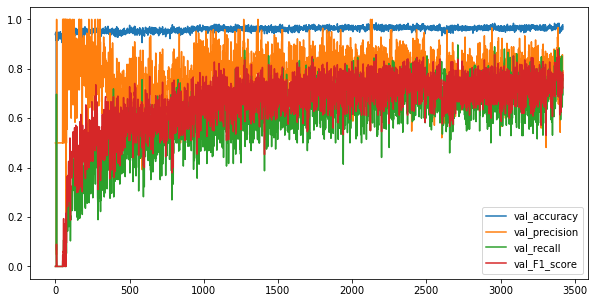

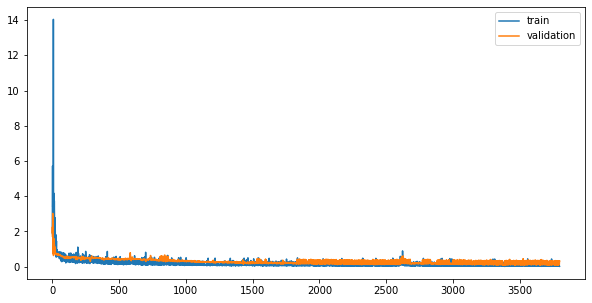

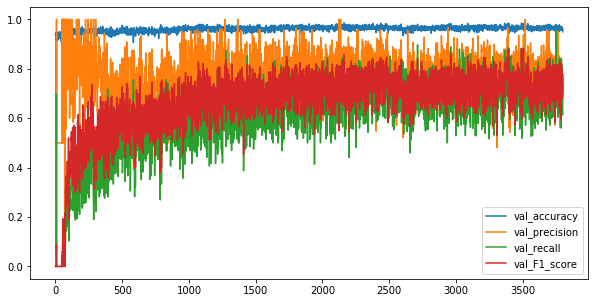

In [3]:
num_epochs = 100
total_step = train_length//500

encoder = CNNEncoder().to(DEVICE)

criterion = nn.BCELoss(reduction='mean')
params = list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

plot_dict = dict()
losses = list()
val_losses = list()
acc = list()
prec = list()
rec = list()
f1 = list()

t0 = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        encoder.train()
        encoder.zero_grad()
        
        inp, label = next(iter(train_loader))
        inp = inp.to(DEVICE)
        label = label.to(DEVICE)
        outputs = encoder(inp).to(DEVICE)
        loss = criterion(outputs, label)
        
        loss.backward()
        optimizer.step()
        
        # - - - Validate - - -
        with torch.no_grad():
            
            encoder.eval()

            val_inp, val_label = next(iter(valid_loader))
            val_inp = val_inp.to(DEVICE)
            val_label = val_label.to(DEVICE)
            val_outputs = encoder(val_inp).to(DEVICE)
            
            val_loss = criterion(val_outputs, val_label)
#             print('\n')
#             for i in range(10):
#                 print(torch.round(val_outputs[i]), val_label[i])
#                 print(torch.round(val_outputs[i]), torch.round(val_label[i]))
#                 print(int(val_outputs[i]), int(val_label[i]))
            val_accuracy, val_precision, val_recall, val_F1_score = metric(val_outputs, val_label)
    
        val_losses.append(val_loss.item())
        losses.append(loss.item())
        acc.append(val_accuracy)
        prec.append(val_precision)
        rec.append(val_recall)
        f1.append(val_F1_score)
        
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
                (epoch, num_epochs, i_step, total_step, loss.item(), val_loss.item(), val_accuracy, val_precision, val_recall, val_F1_score)
        
        print('\r', stats, end="")
        
#         f = sys.stdout
#         f = path
#         print(stats, 'Process in [%d/%d] step' % (i_step, total_step), file=f)
        
    print('\r', stats)
    
    plot_dict['val_losses'] = val_losses
    plot_dict['losses'] = losses
    plot_dict['acc'] = acc
    plot_dict['prec'] = prec
    plot_dict['rec'] = rec
    plot_dict['f1'] = f1
    
    if epoch == 1 or epoch == 3 or epoch == 5 or epoch%10 == 0:
        save_fig('imbalance', epoch, plot_dict)
    

t1 = time.time()

print('finished in {} seconds'.format(t1 - t0))

In [ ]:
with torch.no_grad():
            
    encoder.eval()

    test_inp, test_label = next(iter(test_loader))
    test_inp = test_inp.to(DEVICE)
    test_label = test_label.to(DEVICE)
    test_outputs = encoder(test_inp).to(DEVICE)

    test_loss = criterion(test_outputs, test_label)
    test_accuracy, test_precision, test_recall, test_F1_score = metric(test_outputs, test_label)
        
stats = 'Loss: %.4f, accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
                (test_loss.item(), test_accuracy, test_precision, test_recall, test_F1_score)
        
print(stats)

In [ ]:
t_data = np.array([idx for idx, label in enumerate(test_label) if int(label) == 1])
plt.figure(figsize=(20, 20))
for i in tqdm(range(24)):
    plt.subplot(8, 3, i+1)
    plt.plot(test_inp[t_data[i]][0].to('cpu'), color='blue' if int(test_outputs[t_data[i]]) == 1 else 'red')

plt.tight_layout()

In [ ]:
f_data = np.array([idx for idx, label in enumerate(test_label) if int(label) == 0])
plt.figure(figsize=(20, 20))
for i in tqdm(range(24)):
    plt.subplot(8, 3, i+1)
    plt.plot(test_inp[f_data[i]][0].to('cpu'), color='red' if int(test_outputs[f_data[i]]) == 0 else 'blue')

plt.tight_layout()